In [1]:
#project NEOM "ResidentialComplex"
#Energy consumption prediction using Deep Learning techniques

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing
from math import sqrt
from keras import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from sklearn.metrics import r2_score
from matplotlib import pyplot

In [36]:
# Function To Get data

def get_data():
    dataset = pd.read_csv('ResidentialComplex1.csv')
    df = pd.DataFrame(dataset)
    #df.drop(df.columns[[4]], axis=1, inplace=True) 

    return df 

In [37]:
# To read data
df = get_data()
df.tail()

,Y,M,D,Temp,ND,WD,EC
3768,2020,4,26,27.9000,2215,1,739009.8420
3769,2020,4,27,29.8000,2215,1,739009.8420
3770,2020,4,28,28.8000,2215,1,739009.8420
3771,2020,4,29,25.4000,2215,1,739009.8420
3772,2020,4,30,26.1000,2215,1,739009.8420


In [38]:
#To check if there missing value or not  


def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans



num_cols = get_cols_with_no_nans(df , 'num')
#cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('Number of numerical columns with no nan values :',len(num_cols))

Number of numerical columns with no nan values : 7


In [39]:
#https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/
# if there missing value : 
#Filling null values with the previous ones
def fill(df):
    df = df.fillna(method ='pad') 
    return df

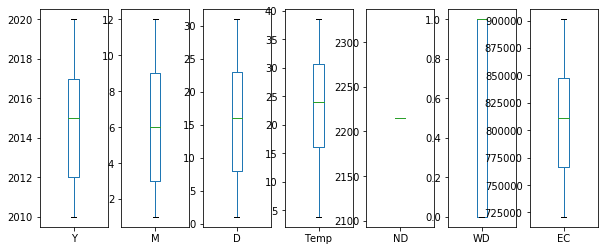

In [40]:
#https://pandas.pydata.org
#Show the range of the data and detect if there Outlier or not : 
#1.5 * IQR (IQR = Q3 - Q1)

df.plot(kind='box',subplots=True,sharex=False,sharey=False , figsize=(10, 4) )

plt.show()

In [41]:
#Normalization  by decimal scaling

df['Y'] = df['Y'] /10000
df['M'] = df['M'] /100
df['D'] = df['D'] /100
df['Temp'] = df['Temp'] /100
df['ND'] = df['ND'] / 10000
df['WD'] = df['WD'] / 10
df['EC'] = df['EC'] / 1000000
df.head(5)


,Y,M,D,Temp,ND,WD,EC
0,0.2010,0.0100,0.0100,0.1260,0.2215,0.0000,0.9011
1,0.2010,0.0100,0.0200,0.1390,0.2215,0.0000,0.9011
2,0.2010,0.0100,0.0300,0.1540,0.2215,0.1000,0.9011
3,0.2010,0.0100,0.0400,0.1470,0.2215,0.1000,0.9011
4,0.2010,0.0100,0.0500,0.1400,0.2215,0.1000,0.9011


In [42]:
#load_data function configured to accept any amount of features
#https://github.com/etai83/lstm_stock_prediction
def load_data(DEC, seq_len):
    amount_of_features = len(DEC.columns)
    #data = DEC.as_matrix() 
    data = DEC.values
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.8 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]


    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [43]:
#Build_model : 

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(64, input_shape=(layers[1], layers[0])))
        model.add(Dropout(d))
        model.add(Dense(16, activation="relu", kernel_initializer="uniform")) 
        model.add(Dense(1, activation="linear", kernel_initializer="uniform"))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [44]:
#Setting X and Y for training and testing
window = 35
X_train, y_train, X_test, y_test = load_data(df[::1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (2990, 35, 7)
y_train (2990,)
X_test (747, 35, 7)
y_test (747,)


In [45]:
# Loading the model sequence structure

model = build_model2([7,window,1])

In [46]:
#Executing the model: 

history = model.fit(
    X_train,
    y_train,
    batch_size=57,
    epochs=315,
    validation_split=0.10,
    verbose=0)

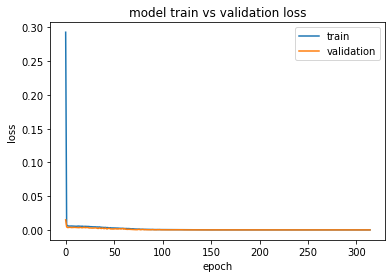

In [47]:
#Check Overfitting : 
#https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [48]:
# Calculate difference & predict

diff=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    diff.append(abs(y_test[u]- pr))

In [49]:
#Performance evaluation metrics


# MSE/RMSE results
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.5f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
print('******************')
                                                                      

y_test_NonZero = y_test.flatten() *10000
p_NonZero =  p.flatten() *10000


MAPE = np.mean(np.abs(((y_test_NonZero - p_NonZero) / y_test_NonZero)) * 100)
print ('MAPE = %.4f' % MAPE )                                                                      
                                                                      
#To calculate accuracy
Accuracy = r2_score(y_test , p) * 100
print("Accuracy = %.2f" % Accuracy , "%" )   
                                                                      
                                                                      


Train Score: 0.00012 MSE (0.01075 RMSE)
Test Score: 0.00012 MSE (0.01104 RMSE)
******************
MAPE = 0.5257
Accuracy = 96.67 %


In [50]:
#medium term pred
Year = X_test[(0+window):(30+window) , 0 , 0] *10000
Month = X_test[(0+window):(30+window) , 0 , 1] *100
Day = X_test[(0+window):(30+window) , 0 , 2] *100

#pd.to_numeric(p, downcast="float")
Actual = y_test.flatten()[0:30] *1000000
pred_value = p.flatten()[0:30] *1000000

pd.options.display.float_format = '{:.4f}'.format

ECP = pd.DataFrame({'Year': np.int_(Year) , 'Month': np.int_(Month), 'Day': np.int_(Day),
                    'Actual (KWH)': Actual, 'Predicted (KWH)': pred_value , 'Diff' : diff[0:30]
})


ECP

,Year,Month,Day,Actual (KWH),Predicted (KWH),Diff
0,2018,4,14,811032.8000,807522.7737,0.0035
1,2018,4,15,739044.2100,806083.7388,0.0670
2,2018,4,16,739044.2100,748298.6450,0.0093
3,2018,4,17,739044.2100,746307.7307,0.0073
4,2018,4,18,739044.2100,741485.4169,0.0024
5,2018,4,19,739044.2100,741208.0765,0.0022
6,2018,4,20,739044.2100,737458.5867,0.0016
7,2018,4,21,739044.2100,736510.7536,0.0025
8,2018,4,22,739009.8420,737600.6842,0.0014
9,2018,4,23,739009.8420,736518.3234,0.0025


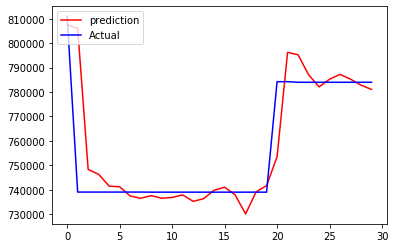

In [51]:
#Predictions vs Real results 

import matplotlib.pyplot as plt2

plt2.plot(pred_value,color='red', label='prediction')
plt2.plot(Actual,color='blue', label='Actual')
plt2.legend(loc='upper left')
plt2.show()


In [52]:
ECP.to_csv('ECResidentialComplex.csv')

In [53]:
# save model and architecture to single file 
model.save("ECResidentialComplexMODEL.h5")
print("Saved model to disk")

Saved model to disk
